# Map Datasets to KinPred

## Download and Process Dataset of Interest
Prior to predicting kinase activities, datasets need to be mapped to KinPred to obtain the Uniprot ID, phosphosite, and the +/-7 peptide sequence that will be used by KSTAR to identify which kinases are associated with each phosphosite. In order to map kinase activities, the dataframe containing phosphoproteomic data should contain each peptides Uniprot accession, as well as either the site number or peptide sequence. If the peptide sequence is used, it should be formatted with only the phosphorylated peptides being lowercased. For example, if a peptide sequence is annotated with '(ph)' in front of the phosphorylated amino acid, you would need to remove the '(ph)' from the sequence and lowercase the phosphorylated amino acid. So, the peptide sequence SGLAYCPND(ph)YHQLFSPR would become SGLAYCPNDyHQLFSPR.

It is recommended to use the peptide sequence rather than the site number when possible, as this is more likely to be found in the most recent version of KinPred. An example of the processed dataset can be seen below, which is a trimmed, processed, and mapped version of the dataset published publically (Chylek, 2014):

Reference:  L. A. Chylek, V. Akimov, J. Dengjel, K. T. G. Rigbolt, B. Hu, W. S. Hlavacek, and B. Blagoev.
Phosphorylation Site Dynamics of Early T-cell Receptor Signaling. PLoS ONE, 9(8):e104240,
2014.

In [1]:
#import KSTAR and other necesary packages
import pandas as pd
import numpy as np
import pickle
import os

from kstar import config, helpers, mapping

In [2]:
#load data
df = pd.read_csv('example.tsv', index_col = 0, sep = '\t')
df

,query_accession,mod_sites,peptide,data:time:0,data:time:5,data:time:15,data:time:30,data:time:60
MS_id,,,,,,,,
7605136,Q9P2D3-1,Y1104,EAAEVCEyAMSLAK,0.0,-0.01,-0.28,-0.03,-0.27
7605137,A0FGR8-6,Y845,NLIAFSEDGSDPyVR,0.0,0.26,0.27,0.04,0.05
7605138,Q5T4S7-2,Y5156,HNDMPIyEAADK,0.0,0.31,-0.15,0.01,-0.23
7605139,Q16181-1,Y30,NLEGyVGFANLPNQVYR,0.0,-0.14,-0.19,0.07,0.15
7605140,Q16181-1,Y41,NLEGYVGFANLPNQVyR,0.0,-0.14,-0.09,0.04,-0.06
...,...,...,...,...,...,...,...,...
7605855,O95801,Y129,AAAQYyLGNFR,0.0,0.15,0.39,-0.05,0.08
7605859,O60711,Y22,STLQDSDEySNPAPLPLDQHSR,0.0,-0.73,0.76,4.48,5.88
7605860,O60711,Y203,SGLAYCPNDyHQLFSPR,0.0,0.55,-1.77,3.58,5.15


Notice that all data columns in the dataset have 'data:' in front of them. This is how KSTAR will identify which columns to use when making evidence decisions. This can be done manually prior to mapping, or will be done by KSTAR automatically once you indicate which columns you would like to use as evidence.

## Map the Dataset to KinPred

First, we need to indicate where to save the mapped data and where to record information about the mapping process:

In [3]:
#define the directory where mapped dataset and run information will be saved. 
odir = './example'
#if directory doesn't exist yet, create it
if not os.path.exists(f"{odir}/MAPPED_DATA"): 
    os.mkdir(f"{odir}/MAPPED_DATA")   

Next, we want to intialize a log file which will record information about the mapping run, including any errors that arise during the process. This log file will be saved in the location indicated by the second parameter of the 'helpers.get_logger()' function.

In [4]:
#Define the log name
logName = 'example_run'
#intialize logger
mapping_log = helpers.get_logger(f"mapping_{logName}", f"{odir}/MAPPED_DATA/mapping_{logName}.log")

The last step before mapping your dataset to KinPred is to construct a dictionary which indicates the columns where KSTAR can find information about each peptide. This should include the 'accession_id', the uniprot accession corresponding to the identified peptide. It should also include __either__ the 'peptide' (amino acid sequence with phosphorylation sites lowercased) or the 'site' (modified amino acid + modification location, such as Y11). It is recommended to use the peptide sequence when possible.

The format of this dictionary should be: {'peptide': 'Col_with_PeptideInfo', 'accession_id': 'Col_with_UniprotID'}

In [5]:
mapDict = {'peptide':'peptide', 'accession_id':'query_accession'}

You are now ready to map the dataset, which can be done using the ExperimentMapper class.

In [6]:
#map dataset and record process in the logger
exp_mapper = mapping.ExperimentMapper(experiment = df,
                                      columns = mapDict, 
                                      logger = mapping_log)
#save mapped dataset
exp_mapper.experiment.to_csv(f"{odir}/MAPPED_DATA/{logName}_mapped.tsv", sep = '\t', index = False)

If you look at the ExperimentMapper class, you will find that five new columns have been added to the original dataset, which allows for easy mapping to KSTAR networks used in activity prediction.

In [7]:
exp_mapper.experiment.head()

,query_accession,mod_sites,peptide,data:time:0,data:time:5,data:time:15,data:time:30,data:time:60,KSTAR_ACCESSION,KSTAR_PEPTIDE,KSTAR_SITE,KSTAR_NUM_COMPENDIA,KSTAR_NUM_COMPENDIA_CLASS
0,Q9P2D3-1,Y1104,EAAEVCEyAMSLAK,0.0,-0.01,-0.28,-0.03,-0.27,Q9P2D3,EAAEVCEyAMSLAKN,Y1104,0,0
1,A0FGR8-6,Y845,NLIAFSEDGSDPyVR,0.0,0.26,0.27,0.04,0.05,A0FGR8,SEDGSDPyVRMYLLP,Y824,2,1
2,Q5T4S7-2,Y5156,HNDMPIyEAADK,0.0,0.31,-0.15,0.01,-0.23,Q5T4S7,RHNDMPIyEAADKAL,Y5135,1,1
3,Q16181-1,Y30,NLEGyVGFANLPNQVYR,0.0,-0.14,-0.19,0.07,0.15,Q16181,QQKNLEGyVGFANLP,Y30,5,2
4,Q16181-1,Y41,NLEGYVGFANLPNQVyR,0.0,-0.14,-0.09,0.04,-0.06,Q16181,ANLPNQVyRKSVKRG,Y41,1,1


These additional columns have the following meaning:

1. 'KSTAR_ACCESSION': Uniprot accession id corresponding to reviewed protein sequence, focusing only on the canonical isoforms of each protein.
2. 'KSTAR_PEPTIDE': Peptide sequence containing a single phosphorylation site, including the 7 amino acids both before and after the modified residue.
3. 'KSTAR_SITE': Location of modified residue in the protein
4. 'KSTAR_NUM_COMPENDIA': The number of different phosphoproteome compendia that modification site is identified in, used as an indicator of the study bias of each modification site. For this purpose, PhosphoSitePlus, PhosphoELM, HPRD, ______, and ProteomeScout were profiled.
5. 'KSTAR_NUM_COMPENDIA_CLASS': Same as 4, but sites are grouped into smaller classes based on study bias (0 is <1 compendia, 1 is 1-3 compendia, 2 is >3 compendia)

## Explore the Mapped Dataset

One way to check how well the mapping worked is to check the number of peptides in the original dataframe vs. the newly mapped dataframe. 

In [8]:
#Look at how many of the peptides in the dataset were actually mapped. This indicates how well the mapping worked
print("Original number of lines in df: %d\nNew number of lines in mapped:%d"%(len(df), len(exp_mapper.experiment)))

Original number of lines in df: 665
New number of lines in mapped:665


In this case, no peptides were lost during the mapping process. Changes to the number of peptides could be a result of several things:
1. Failure to find the corresponding peptide 
2. A peptide with multiple phosphorylation sites was seperated into seperate peptides

For specifics on mapping failures, go to the log file for details.

# Predict Kinase Activities

Once pruned networks have been generated or downloaded and data has been mapped, you are now ready to generate kinase activity predictions. Kinase activity calculation requires selection of the following choices

1. *phospho_type:* Tyrosine ['Y'] or Serine/Threonine ['ST'], or both ['Y, 'ST'] (default). 
2. *agg:* How to handle duplicates of the same peptide (i.e. aggregation) and determine sites to use as evidence. a) 'count' counts the total number of times a non-NaN value of that peptide occurred in an experiment, and accepts any site that appears an amount of times equal to or above the threshold. This is recommended if you do not want to use quantification values and instead want to focus only on sites identified in each sample. b) 'mean' averages the non-NaN values found for multiple peptides. We recommend using this when you do want to use quantification values, such as when comparing a pre and post treatment condition.
3. *threshold:* defines which of the phosphorylation sites to use as evidence for each condition. If greater == True (default), any site with an aggregated value greater than the threshold will be used as evidence for prediction for each condition. If greater == False, any site with an aggreagated value less than the threshold will be used as evidence for prediction for each condition.

In [9]:
#Import preamble of kstar and other necessary functions
import pandas as pd
import os
import pickle

from kstar import config, helpers, calculate

## Determine Thresholds
It is useful to determine the best threshold to use (which sites to use as evidence for each sample). One easy benchmark way is to identify the number of sites that will be used as evidence at different thresholds. For tyrosine kinase activities, it is generally recommended that samples have at least 50 tyrosine sites used as evidence, while for serine/threonine kinase activities, it is recommended that samples have at least 1000 sites used as evidence. While not a necessity, it is also beneficial to have comparable site numbers across samples.

Similar to mapping, a log file will be generated to indicate the progress of activity prediction and any errors that arise during the process. To intialize the log file, run the below code. It can be useful to name your log files differently based on whether you are generating predictions for tyrosine kinases or serine/threonine kinases.

In [10]:
#define the directory where mapped dataset and run information will be saved. 
odir = './example'
logName = 'example_run'
#Name
logName_new = logName + '_Y'
#if directory does not exits, create it
if not os.path.exists(f"{odir}/RESULTS"): 
    os.mkdir(f"{odir}/RESULTS")
#intialize log file
activity_log = helpers.get_logger(f"activity_{logName_new}", f"{odir}/RESULTS/activity_{logName_new}.log")

In [11]:
#load mapped data, if necessary
experiment = pd.read_csv(f'{odir}/MAPPED_DATA/{logName}_mapped.tsv', sep = '\t', index_col = 0)

Next, we need to define the parameters to use for the generation of evidence in this experiment. These parameters include:
1. data_columns: the location of abundance values from phosphoproteomic experiment. Either can provide a list of column names, or if is None, KSTAR will look for any column that contains 'data:' at the beginning of the name. Since the example dataset includes this 'data:' format, we will set this parameter to None.
2. agg: We would like phosphorylation sites select sites based on the their abundance relative to the pre-stimulation condition, with sites appearing multiple times aggregated using a mean. As such, we will set this to be 'mean'.
3. greater: boolean that indicates whether sites greater than or less than the threshold should be kept. We are interested in knowing which kinases activate upon TCR stimulation, so we want to look at phosphorylation sites with phosphorylation. For this reason, we will set greater = True.
3. threshold: This will define the cutoff for keeping a phosphorylation site as evidence. If we look at the original data, abundance values are relative to the 0 minute timepoint and appear to be log transformed. We want to focus on kinases that have increased activity after stimulation, so we think that 0.2 (phosphorylation sites logfold change >0.2 used as evidnece) will be  a good threshold.

In [12]:
#Define parameters
data_columns = None
agg = 'mean' 
greater = True
threshold = 0.2

For all activity prediction steps, the KinaseActivity class (found within the calculate module) is used. To initialize the class, you only need to provide the original experiment, the logger, the data columns with abundance information, and the modification type of interest. We can then use the KinaseActivity class to determine the sites that will be used as evidence in each condition given a threshold of 2.

In [13]:
#intialize KinaseActivity class object
kinact = calculate.KinaseActivity(experiment, activity_log,data_columns = data_columns, phospho_type=['Y'])
#convert evidence into binary evidence based on the provided threshold
evidence_binary = kinact.create_binary_evidence(agg = agg, threshold = threshold,  greater = True)

Now that we have the binary evidence that will be used as prediction, we can identify the number of sites that will be used as evidence for prediction for each condition:

In [14]:
#inspect the number of sites used for each sample
data_cols = [col for col in evidence_binary.columns if 'data:' in col]
evidence_binary[data_cols].sum()

data:time:0       0.0
data:time:5     128.0
data:time:15    135.0
data:time:30    191.0
data:time:60    200.0
dtype: float64

All samples above (except for the 0 time point, which will be removed prior to activity calculation) have greater than 50 sites being used as evidence, and the evidence sizes are generally comparable. This is a good threshold to use.

## Calculate Statistical Enrichment (Hypergeometric p-values)

The first step to obtaining activity predictions is calculating the statistical enrichment of kinase substrates in the dataset using the hypergeometric test. For each network + kinase, the hypergeometric tests asks the likelihood that k kinase substrates were identified in an experiment with n identified peptides, given that there are K kinase substrates in the entire phosphoproteome, N. From these tests, a set of 50 p-values for each kinase will be generated indicating the enrichment found in each pruned network. To obtain these predictions, use the following steps

1. Load the pruned kinase-substrate networks from the network pickles. Since the example dataset provided here is tyrosine enriched, using tyrosine networks. 

In [15]:
phospho_types = ['Y'] #running on this type of kinase/substrate network

#Load the pickles containing the 50 pruned networks for tyrosine kinases
networks = {}
networks['Y'] = pickle.load(open(config.NETWORK_Y_PICKLE, "rb" ) )

2. Initialize an activity log, which will store information about each run, including any errors that arise

In [16]:
#Create activity log: if already did this, ignore.
if not os.path.exists(f"{odir}/RESULTS"): 
    os.mkdir(f"{odir}/RESULTS")
activity_log = helpers.get_logger(f"activity_{logName}", f"{odir}/RESULTS/activity_{logName}.log")

3. Define the parameter values to use for activity calculation. These are the same as those described in the 'Determine Threshold' section for generating binary evidence.

In [17]:
data_columns = None #by passing None, all columns prefixed by data: will be used to calculate activity
agg = 'mean'
threshold = 0.2
greater = True

4. Perform enrichment calculations. The enrichment_analysis() function within the calculate module can be used to generate the statistical enrichment values. This will return a dictionary containing a different KinaseActivity object for each modification type with predictions ('Y' and/or 'ST).

In [18]:
kinact_dict = calculate.enrichment_analysis(experiment, activity_log, networks, phospho_types = phospho_types, 
                                                agg =agg, threshold = threshold,  
                                                greater = greater, PROCESSES = 1)

You can view the median p-values obtained for each kinase by looking at 'activities' attribute of the KinaseActivity class. We recommend continuing to the subsequent sections to generate more robust activity predictions, as the we have found that the median p-values suffer from kinase-specific false positive rates.

## Generate random datasets, run kinase activity on random datasets, normalize original analysis

Once the enrichment of each kinase in the pruned networks has been calculated from the enrichment_analysis() function, we would next like to ask, for each kinase, how likely it is to have obtained that same enrichment (as indicated by the p-value) or better from a random phosphoproteomic experiment. To do so, we will first need to generate random phosphoproteomic experiments and repeat hypergeometric enrichment on these experiments. In order to perform random activity calculation, you will need to indicate the number of random experiments to generate. We have found that 150 provides a good balance between statistical power and computational complexity. 

*Note: For larger datasets this can be slow and memory intensive. In order to speed up these calculations, it is possible to use multiprocessing by adjusting the 'PROCESSES' parameter to the number of core you would like to use. The default is 1 (use only a single core). You can also use a highly parallelized version through nextflow (see 'KSTAR in Parallel')*

In [19]:
#Set the number of random experiments
num_random_experiments=150
#Generate random experiments
calculate.randomized_analysis(kinact_dict, activity_log, num_random_experiments, PROCESSES = 1)

The random experiments generated from the above function can be found in the 'random_experiments' attribute of the KinaseActivity class. For each random experiment, the sites that will be included for random activity generation are indicated with 1.

In [20]:
#This object holds the random datasets that were used, where NaN means a site was not selected and 1 means it was
kinact_dict['Y'].random_experiments.head()

,KSTAR_ACCESSION,KSTAR_SITE,data:time:5:0,data:time:5:1,data:time:5:2,data:time:5:3,data:time:5:4,data:time:5:5,data:time:5:6,data:time:5:7,...,data:time:60:140,data:time:60:141,data:time:60:142,data:time:60:143,data:time:60:144,data:time:60:145,data:time:60:146,data:time:60:147,data:time:60:148,data:time:60:149
0,A0AUZ9,Y792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A0AV02,Y107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A0AVF1,Y174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A0AVI2,Y1801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,A0AVK6,Y202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


If you sum the random experiments object, it will tell you how many total sites were selected for each random experiment, which should match the parent experiment:

In [21]:
# If you sum the random_experiments it will tell you how many total sites were selected, which should match
# the parent experiment 
kinact_dict['Y'].random_experiments.sum()

KSTAR_ACCESSION     A0AUZ9A0AV02A0AVF1A0AVI2A0AVK6A0AVK6A0AVT1A0AV...
KSTAR_SITE          Y792Y107Y174Y1801Y202Y316Y1046Y44Y558Y979Y824Y...
data:time:5:0                                                   128.0
data:time:5:1                                                   128.0
data:time:5:2                                                   128.0
                                          ...                        
data:time:60:145                                                200.0
data:time:60:146                                                200.0
data:time:60:147                                                200.0
data:time:60:148                                                200.0
data:time:60:149                                                200.0
Length: 602, dtype: object

## Calculate Mann Whitney Significance

Finally, final activity scores are calculated by implementing the Mann Whitney U-test to compare the distribution of real p-values (activity predictions on the real dataset) to the random p-values (activity predictions on the random dataset). Further, a false positive rate is calculated by pulling out one of the random datasets and comparing to all other random datasets using the same Mann Whitney test. The parameter 'number_sig_trials' indicates the number of times to repeat this calculation to obtain the false positive rate. As with the previous analysis, the 'PROCESSES' parameter can be adjusted to perform multiprocessing.

In [22]:
calculate.Mann_Whitney_analysis(kinact_dict, activity_log, number_sig_trials = 100, PROCESSES = 1)

## Save KSTAR Results

There are a couple of options to save the results of KSTAR analysis. To save all information (hypergeometric enrichment results, random experiments, mann whitney activities and fpr), we have provided a function to save all information while not taking up too much memory.

In [ ]:
calculate.save_kstar_slim(kinact_dict, logName, odir)

Lastly, it is possible to just save each KinaseActivity attribute individually using pandas:

In [ ]:
kinact_dict['Y'].activities_mann_whitney.to_csv(f'{logName}_Y_mann_whitney_activities.tsv', sep = '\t')
kinact_dict['Y'].fpr_mann_whitney.to_csv(f'{logName}_Y_mann_whitney_fpr.tsv', sep = '\t')

# Plot Results
Kinase activities predicted by KSTAR can be visualized using a specialized plot called a dotplot. In these plots, the size of each "dot" is dictated by the -log10(p-value) and the color is dicated by the false positive rate (significance).

In [24]:
#import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kstar.plot import DotPlot
from kstar import helpers, config, calculate

In [25]:
odir = './example'
logName = 'example_run'
phosphomod = 'Y'
logName_new = f"{logName}_{phosphomod}"
#get activity log
activity_log = helpers.get_logger(f"activity_{logName}", f"{odir}/RESULTS/activity_{logName}.log")

## Load in KSTAR results

To load a kstar_slim save, use the 'from_kstar_slim' function

In [27]:
#Load kstar_slim save
kinact_dict = calculate.from_kstar_slim(logName, odir, activity_log)

If nextflow was used (see Running Large Datasets with Nextflow), there is a seperate function that will allow you to load in results from nextflow into a kinase_dict object:

In [28]:
kinact_dict = calculate.from_kstar_nextflow(name = 'example_run',odir = 'example_run')

Lastly, you may only be concerned about the predicted activities and false positive rates. If that is the case, load these directly with pandas:

In [29]:
results = pd.read_csv(f"{odir}/RESULTS/{logName}_Y_mann_whitney_activities.tsv", sep = '\t', index_col = 0)
fpr = pd.read_csv(f"{odir}/RESULTS/{logName}_Y_mann_whitney_fpr.tsv", sep = '\t', index_col = 0)

## Plot the base dotplot

In the most simple case, we can plot all kinases and samples with activity predictions, sorted in the same order as the provided activities/fpr dataframe. First, we need to extract the activity and false positive rate from the kinact_dict object.

In [26]:
#if using kinase_dict object, extract results and fpr values
activities = kinact_dict['Y'].activities_mann_whitney.copy()
fpr = kinact_dict['Y'].fpr_mann_whitney.copy()

Activities first need to be transformed to activity scores, a log transformed version of the Mann Whitney p-values. Doing so makes it so that the activity score increases with increase kinase activity.

In [27]:
#log transform the results: this will make visualization much easier
log_results = -np.log10(activities)

To generate a dotplot, the DotPlot class can be used. First, instantiate the class to construct the base dotplot. To show the dotplot, use the dotplot() function.

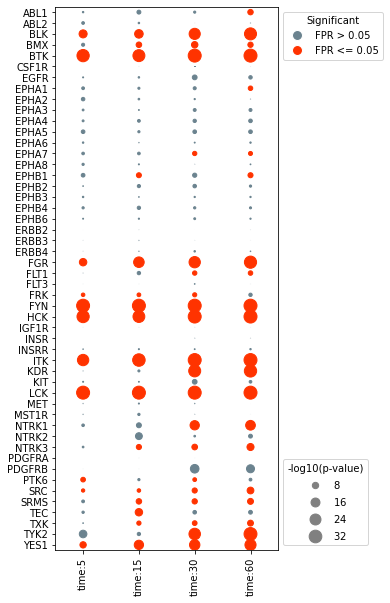

In [28]:
#instantiate the dotplot object
dots = DotPlot(log_results, 
               fpr, 
               figsize = (4,10),
               legend_title = '-log10(p-value)')


#generate the dotplot
dots.dotplot()
plt.show()

## Change the axis labels and sort kinases based on activity

In many cases, you may wish to plot different axis labels for each experiment or use different naming conventions then those that are defaults in NetworKIN. To adjust, you can manually update the results and fpr dataframe prior to creating the dotplot object. Or, you can pass in dictionaries to the dotplot object that will adjust the axis labels accordingly without changing the original activities/fpr dataframes.

In this example, the x-axis labels are a bit wordy. Let's simplify it to just include the numeric time value. In addition, we would like to change the kinase labels so that kinases like KDR (VEGFR2) are indicated by their more well known name.

In [29]:
#create the xlabel dict to remove 'data' and 'time' from x-axis labels
x_label_dict = {}
for i in range(len(activities.columns)):
    x_label_dict[activities.columns[i]] = activities.columns[i].split(':')[2]
    
x_label_dict

{'data:time:5': '5',
 'data:time:15': '15',
 'data:time:30': '30',
 'data:time:60': '60'}

In addition, we would like to change the kinase labels so that kinases like KDR (VEGFR2) are indicated by their more well known name.

In [30]:
#set preferred kinase names (make a kinase_dict)
kinase_dict = {}
kinase_map = pd.read_csv('globalKinaseMap.csv', index_col = 0)
for kinase in activities.index:
    kinase_dict[kinase] = kinase_map.loc[kinase,'Preferred Name']

Any sorting of the results needs to be done before instantiating the dotplot. Only the activities dataframe needs to be updated, the fpr dataframe will be automatically updated in order to match the activities dataframe.

In [31]:
#sort the data by the activities at the 30 second timepoint
log_results.sort_values(by = 'data:time:30', inplace = True)
#reorder axis labels to be in time order
log_results = log_results[['data:time:5','data:time:15','data:time:30', 'data:time:60']]

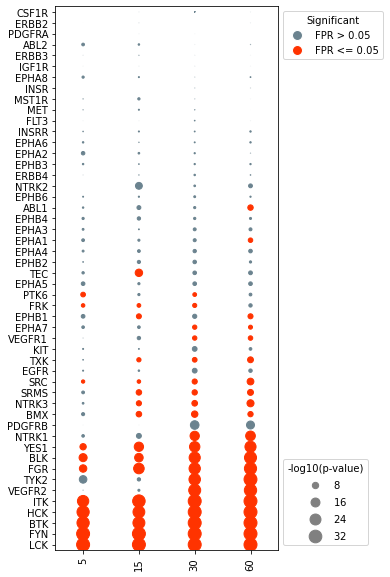

In [32]:
#reinstantiate the dotplot object
dots = DotPlot(log_results, 
               fpr, 
               x_label_dict = x_label_dict,
               kinase_dict = kinase_dict,
               figsize = (4,10),
               legend_title = '-log10(p-value)')

#plot
dots.dotplot()
plt.show()

## Remove kinases that never show significant activity

In many cases, there will be kinases that do not show significant activity in any of the experiments. It can be advantageous to remove these kinases in order to simplify the plot.

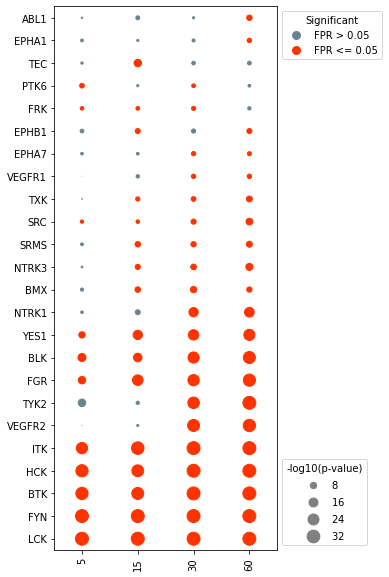

In [33]:
#drop kinases with that are not significant for any of the samples (fpr <= alpha). 
dots.drop_kinases_with_no_significance()

#generate the dotplot
dots.dotplot()
plt.show()

Specific kinases can also be removed prior to plotting. For example, say we were less interested in the activity in EPHA kinases. We can tell the dotplot object to remove these kinases specifically.

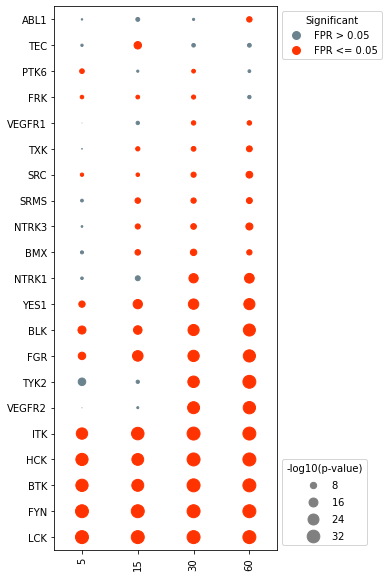

In [34]:
#drop kinases that are not of interest. For example, we may not be interested in visualizing EPHA kinases.
eph = [kin for kin in log_results.index if 'EPHA' in kin or 'EPHB' in kin]
dots.drop_kinases(eph)

#generate the dotplot
dots.dotplot()
plt.show()

## Cluster the kinase activities

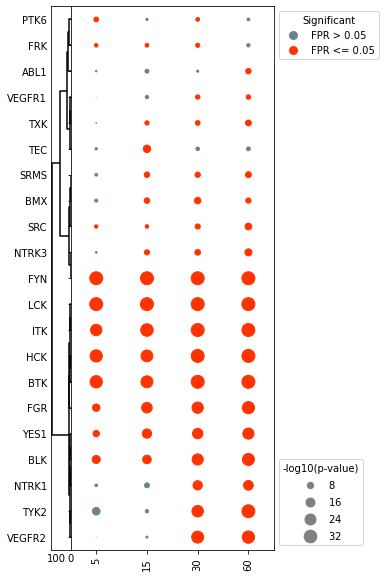

In [35]:
#Setup subplots so that dendrogram are included
fig, axes = plt.subplots(figsize = (4, 10), 
        nrows = 1, ncols = 2, 
        sharex = 'col', 
        sharey = 'row',
        gridspec_kw = {
            'width_ratios':[0.1,1]
        },)
fig.subplots_adjust(wspace=0, hspace=0)

#cluster the kinases with hierarchical clustering, sort them accordingly,and add a dendrogram to the left of the dotplot
dots.cluster(orientation = 'left', ax = axes[0], method='ward')
#cluster the samples with hierarchical clustering, sort them accordingly, and add a dendrogram to the top of the dotplot
#dots.cluster(orientation = 'top', ax = axes[0,1], method='ward')

#generate the dotplot
dots.dotplot(ax = axes[1])
plt.show()

Notice that clustering the kinase activities resorted the y-axis, undoing the sorting from earlier.

## Add context to dotplot

In some cases you may want to add additional context to the dotplot that indicates significant characteristics about each sample. These could include things like pre vs. post-treatment, normal vs. tumor sample, subtype of cancer, etc. 

To do so, you need to create a new dataframe, which contains a row for each sample in the dotplot (with an id column indicating the sample), and columns for each layer of context you want to be added. In the below example, we will add "Context 1" to the plot, which is either true or false. "Context 2" has multiple different options indicated by a number.

In [36]:
#create context dataframe which indicates different information about each sample
context = pd.DataFrame({'Sample': activities.columns, 'Context 1': ['Yes','Yes','No','No'], 'Context 2': ['0','1','2','3']})
context

,Sample,Context 1,Context 2
0,data:time:5,Yes,0
1,data:time:15,Yes,1
2,data:time:30,No,2
3,data:time:60,No,3


Next to plot, with the context information above, setup your subplots as before, but this time, make sure to add another subplot row above the dotplot, which will contain the context strip.

You can then use the 'context' function to create the strip plot. The 'info' parameter should point to the context dataframe, while the 'id_column' should list the column name that contains the sample names, and the 'context_columns' should be a list containing all column names with the desired context. If you choose to also sort your samples by hierarchical clustering, you should do this before generating your context strip (otherwise the sorted samples will not match the context). The result is below:

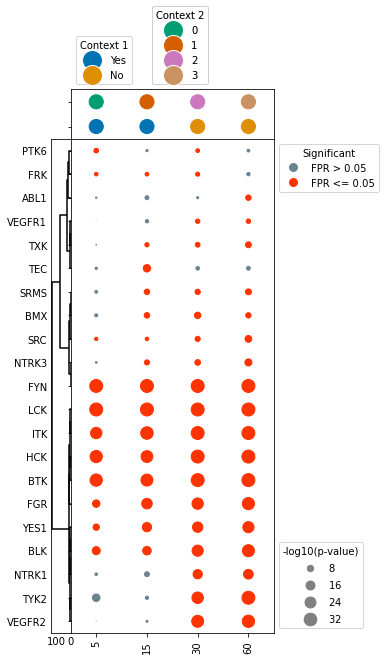

In [37]:
#Setup subplots so that dendrogram and context are included
fig, axes = plt.subplots(figsize = (4, 10), 
        nrows = 2, ncols = 2, 
        sharex = 'col', 
        sharey = 'row',
        gridspec_kw = {
            'height_ratios':[0.1, 1], 
            'width_ratios':[0.1,1]
        },)
fig.subplots_adjust(wspace=0, hspace=0)

#cluster the kinases with hierarchical clustering, sort them accordingly,and add a dendrogram to the left of the dotplot
dots.cluster(orientation = 'left', ax = axes[1,0], method='ward')

#add context to plot (if clustering the experiments, this must come after clustering)
dots.context(ax=axes[0,1],info = context, id_column = 'Sample', 
             context_columns = ['Context 1', 'Context 2'], orientation = 'top', margin = 0.5)

#generate the dotplot
dots.dotplot(ax = axes[1,1])

axes[0,0].axis('off')
plt.show()

## Plot dotplot with the false positive rate indicated by hue

In some cases, the binary coloring of significance can make certain kinases appear less significant than they really are, with false positive rates hovering around 0.05. As such, it may be of interest to encode the false positive rate using a gradient hue instead. This is easy to accomplish in the dotplot class, as this is controlled by the binary_sig parameter.

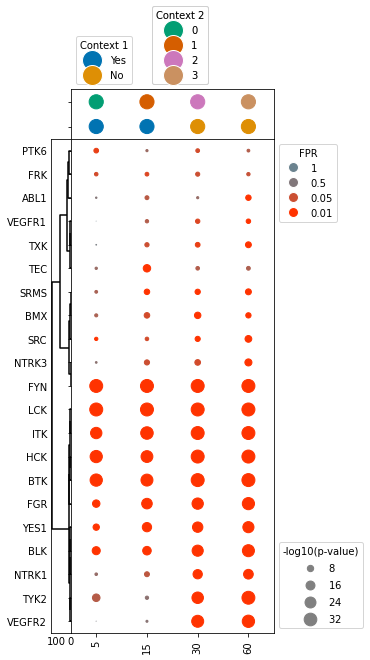

In [38]:
#Setup subplots so that dendrogram and context are included
fig, axes = plt.subplots(figsize = (4, 10), 
        nrows = 2, ncols = 2, 
        sharex = 'col', 
        sharey = 'row',
        gridspec_kw = {
            'height_ratios':[0.1, 1], 
            'width_ratios':[0.1,1]
        },)
fig.subplots_adjust(wspace=0, hspace=0)

#reinstantiate the dotplot object, this time with binary_sig set to False
dots = DotPlot(log_results, 
               fpr, 
               binary_sig = False, #change this parameter
               x_label_dict = x_label_dict,
               kinase_dict = kinase_dict,
               legend_title = '-log10(p-value)')

#repeat the same processing steps as before
dots.drop_kinases_with_no_significance()
eph = [kin for kin in log_results.index if 'EPHA' in kin or 'EPHB' in kin]
dots.drop_kinases(eph)
dots.cluster(orientation = 'left', ax = axes[1,0], method='ward')
dots.context(ax=axes[0,1],info = context, id_column = 'Sample', 
             context_columns = ['Context 1', 'Context 2'], orientation = 'top', margin = 0.5)


#generate the dotplot
dots.dotplot(ax = axes[1,1])

axes[0,0].axis('off')
plt.show()